# FakeCheck - Classifying Whether an Image of Human Face Is Real or Fake

## About the Notebook (Exploratory Data Analysis):


In this notebook, we mostly perform EDA (Exploratory Data Analysis) on human faces  for detecting fake human faces. The EDA is an important step in the data science process, as it allows us to get a deeper understanding of the data and identify any potential issues that need to be addressed.
This notebook will attempt to address the questions by covering the following topics:
<br>
a)What do the images of real and fake human faces look like?
<br>
b)Compare the intensity of each of the R/G/B Channels on grayscale for Real/Fake Images
<br>
c)How does a Real Image look in each of the RGB Channels?
<br>
d)Does the mean RGB channel analysis of each image help in differentiating between real and fake images?
<br>
e)Contribution of each channel in creation of a single Real and Fake Human Face
<br>
f)The average contribution of each channel across all stacked real and fake images
<br>
g)The difference in density between the RGB channels in real and fake images for the whole sample space


## Imports, Settings and Globals:

In [1]:
import os
import pathlib
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from PIL import Image

import PIL
import json
import sklearn
import cv2
import sys
import pandas as pd

from pprint import pprint
from collections import defaultdict
import gc

import tensorflow as tf
from keras_preprocessing.image import load_img
from keras.layers import (Dense, Flatten, Dropout)
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

import warnings
from skimage import io 
import imageio
import time
warnings.filterwarnings(action='ignore')

## Read Raw Data:

In [2]:
start_time = time.time()
sliced_train_images_real = glob("../../Notebooks/real_vs_fake/real-vs-fake/train/real/*")
sliced_train_images_fake = glob("../../Notebooks/real_vs_fake/real-vs-fake/train/fake/*")
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5984373092651367 seconds ---


### Real Human Face Images Sample:

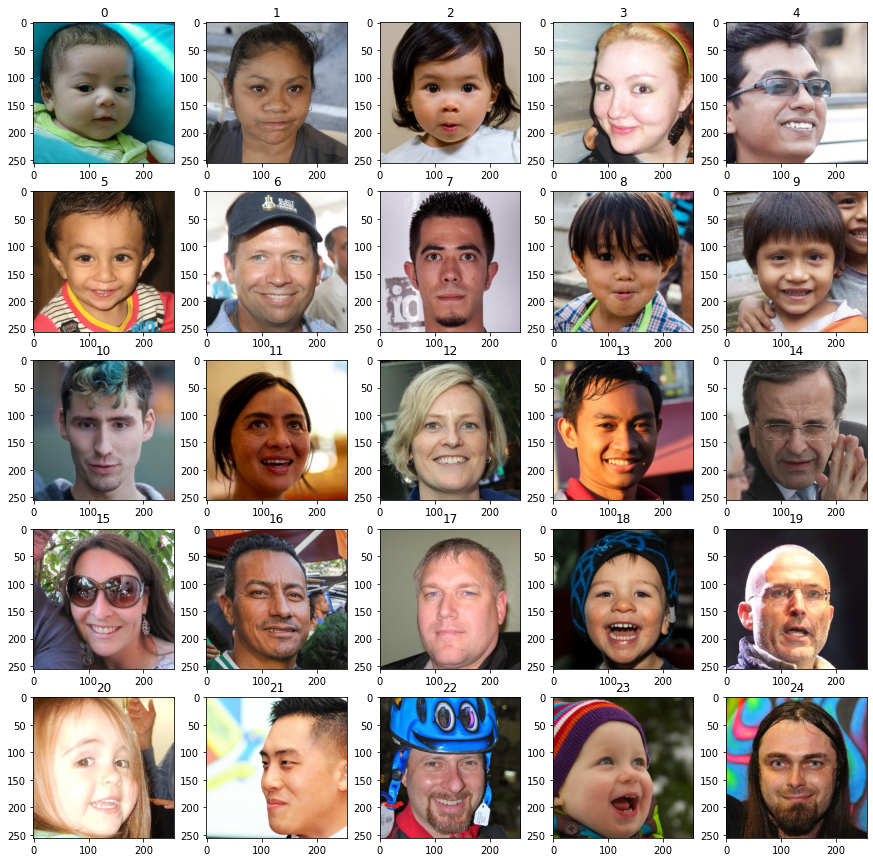

In [3]:
# Displaying Real Human Face Images Sample:
fig, axes = plt.subplots(5,5, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    img = io.imread(sliced_train_images_real[i])
    ax.imshow(img); ax.set_title(i)

### Real Human Face Images Sample:

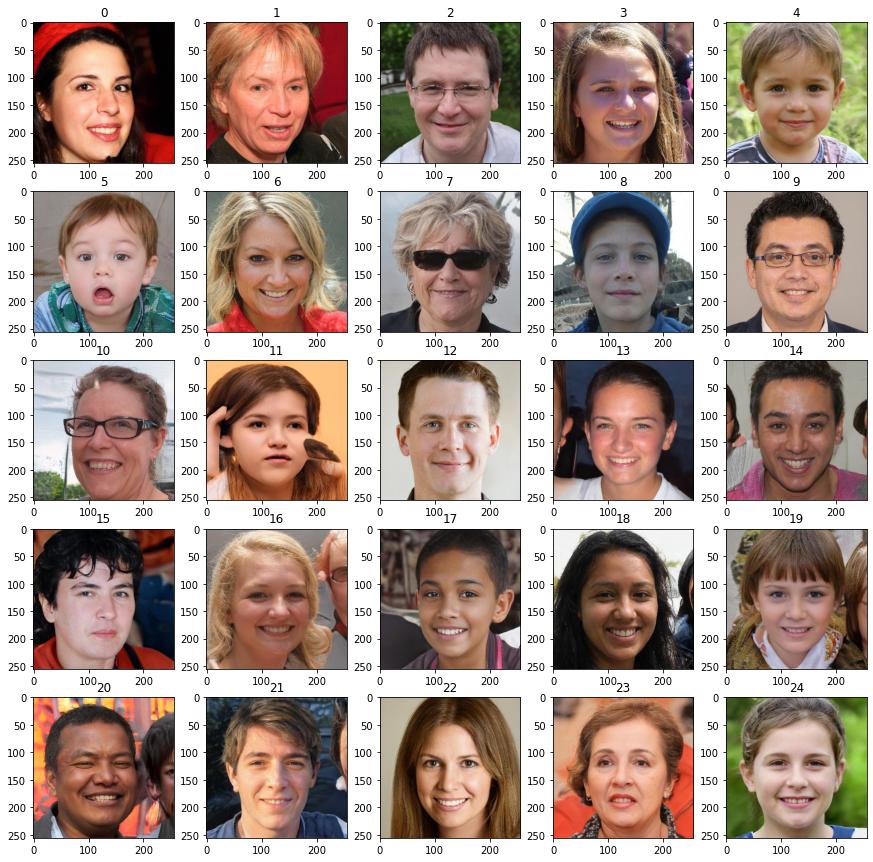

In [5]:
# Displaying Fake Human Face Images Sample:
fig, axes = plt.subplots(5,5, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    img = io.imread(sliced_train_images_fake[i])
    ax.imshow(img); ax.set_title(i)

In [6]:
channels = ['Red', 'Green', 'Blue']

img_real_ids = np.arange(0,50000)
img_fake_ids = np.arange(0,50000)

In [7]:
imgs_real = []
imgs_fake = []

# To store mean values of RGB intensity per image
im_real_mean_rgb_data = defaultdict(list)
im_fake_mean_rgb_data = defaultdict(list)

start_time = time.time()

for i in img_real_ids:
    img = io.imread(sliced_train_images_real[i])
    imgs_real.append(img)
    im_real_mean_rgb_data['idx'].append(sliced_train_images_real[i].split('\\')[1][:-4])
    im_real_mean_rgb_data['r_mean'].append(np.mean(img[:,:,0]))
    im_real_mean_rgb_data['g_mean'].append(np.mean(img[:,:,1]))
    im_real_mean_rgb_data['b_mean'].append(np.mean(img[:,:,2]))
    
for i in img_fake_ids:
    img = io.imread(sliced_train_images_fake[i])
    imgs_fake.append(img)
    im_fake_mean_rgb_data['idx'].append(sliced_train_images_fake[i].split('\\')[1][:-4])
    im_fake_mean_rgb_data['r_mean'].append(np.mean(img[:,:,0]))
    im_fake_mean_rgb_data['g_mean'].append(np.mean(img[:,:,1]))
    im_fake_mean_rgb_data['b_mean'].append(np.mean(img[:,:,2]))

print("--- %s seconds ---" % (time.time() - start_time))  

# Dimensions of images in REAL and FAKE dataset:  
imgs_real[0].shape, imgs_fake[0].shape

--- 414.4383478164673 seconds ---


((256, 256, 3), (256, 256, 3))

### Observations:
All the images in the REAL and FAKE dataset are of dimensions (256, 256, 3) i.e. 256x256 pixels image with 3 channels corresponding to the (R,G,B) colors.

### Plotting a sample image to compare the intensity of each channel on gray-scale:

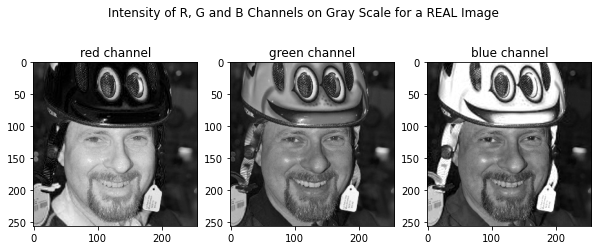

In [15]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
channels = ['red', 'green', 'blue']
for i, ax in enumerate(ax):
    ax.imshow(imgs_real[22][:,:,i], cmap='gray')
    ax.set_title(channels[i]+' channel')
plt.suptitle("Intensity of R, G and B Channels on Gray Scale for a REAL Image")
plt.show()


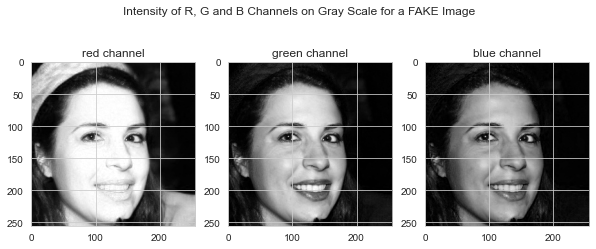

In [195]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
channels = ['red', 'green', 'blue']
for i, ax in enumerate(ax):
    ax.imshow(imgs_fake[0][:,:,i], cmap='gray')
    ax.set_title(channels[i]+' channel')
plt.suptitle("Intensity of R, G and B Channels on Gray Scale for a FAKE Image ")
plt.show()


### Observations:

- Here one image is taken out from each of the REAL and FAKE images dataset and displayed in gray-scale to represent a single channel (R or G or B). 
- For Gray scale images: The regions containing red colour in the original image are lighter in the red channel image. This simply means that, regions which contribute more to the red colour of the original image are lighter in the gray-scale image of the red channel. And the regions which contribute less or do not contribute are dark.
- Similar is the case for blue and green channels too.

#### Plotting a sample image to compare the intensity of each channel using R, G, and B channels:

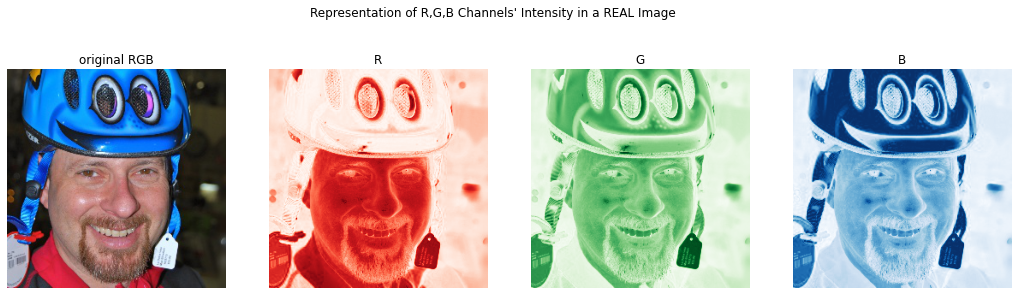

In [11]:
fig, ax = plt.subplots(1, 4, figsize = (18, 5))
ax[0].imshow(imgs_real[22]) 
ax[0].axis('off')
ax[0].set_title('original RGB')
for i, cmap in enumerate(['Reds','Greens','Blues']):
    ax[i+1].imshow(imgs_real[22][:,:,i], cmap=cmap) 
    ax[i+1].axis('off')
    ax[i+1].set_title(cmap[0])
plt.suptitle("Representation of R,G,B Channels' Intensity in a REAL Image")
plt.show()

### Observations:

- For R,G, and B scale images: The regions containing red colour in the original image are darker in the red channel image and the regions which contribute less or do not contribute are lighter. Similar are the cases for Green and Blue channels.

## RGB Analysis:

In [197]:
img_real = imgs_real[0]
img_fake = imgs_fake[0]

img_real_channels = [img_real[0], img_real[1], img_real[2]]
img_fake_channels = [img_fake[0], img_fake[1], img_fake[2]]

### Objective 1:
#### We will try to find out if there is a difference in the distribution of number of images with mean RGB values(calculated for each image individually) 

In [198]:
real_image_mean_rgb_df=pd.DataFrame.from_dict(im_real_mean_rgb_data,orient='columns')
fake_image_mean_rgb_df=pd.DataFrame.from_dict(im_fake_mean_rgb_data,orient='columns')

Text(0, 0.5, 'Density Distribution')

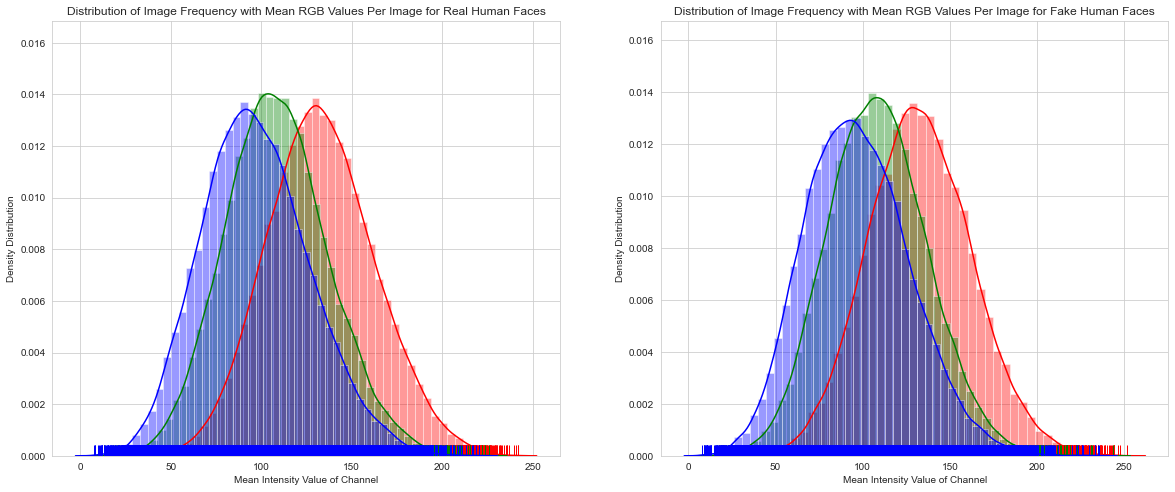

In [199]:
plt.figure(figsize = [20, 8])

plt.subplot(1, 2, 1)
sns.set_style('whitegrid')
sns.distplot(real_image_mean_rgb_df['r_mean'], kde=True, color = 'red', rug=True)
sns.distplot(real_image_mean_rgb_df['g_mean'], kde=True, color = 'green', rug=True)
sns.distplot(real_image_mean_rgb_df['b_mean'], kde=True, color = 'blue', rug=True)
plt.title('Distribution of Image Frequency with Mean RGB Values Per Image for Real Human Faces')
plt.xlabel("Mean Intensity Value of Channel")
plt.ylabel("Density Distribution")


plt.subplot(1, 2, 2)
sns.set_style('whitegrid')
sns.distplot(fake_image_mean_rgb_df['r_mean'], kde=True, color = 'red', rug=True)
sns.distplot(fake_image_mean_rgb_df['g_mean'], kde=True, color = 'green', rug=True)
sns.distplot(fake_image_mean_rgb_df['b_mean'], kde=True, color = 'blue', rug=True)
plt.title('Distribution of Image Frequency with Mean RGB Values Per Image for Fake Human Faces')
plt.xlabel("Mean Intensity Value of Channel")
plt.ylabel("Density Distribution")

### Observations:

##### There is no significant difference in the distribution of number of images based on the R, G and B mean intensity contribution to each image. 

### Objective 2: 
#### Trying to find the RGB channels' density difference for Real and Fake Images (Using single example):

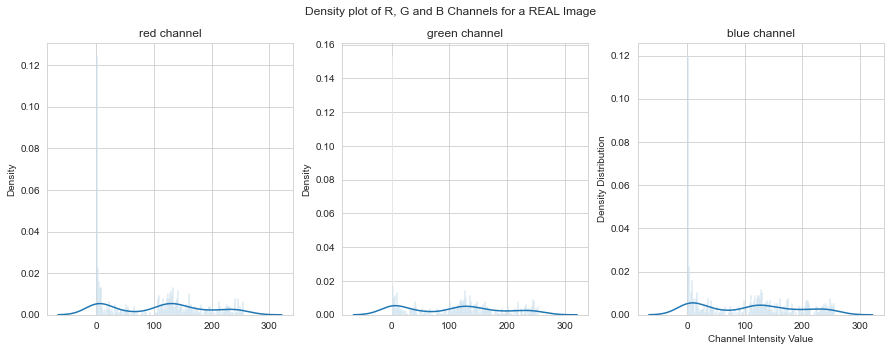

In [200]:
# REAL face image analysis
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(ax):
    df = img_real_channels[i].ravel()
    sns.distplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(channels[i]+' channel')
plt.suptitle("Density plot of R, G and B Channels for a REAL Image ")
plt.xlabel("Channel Intensity Value")
plt.ylabel("Density Distribution")
plt.show()


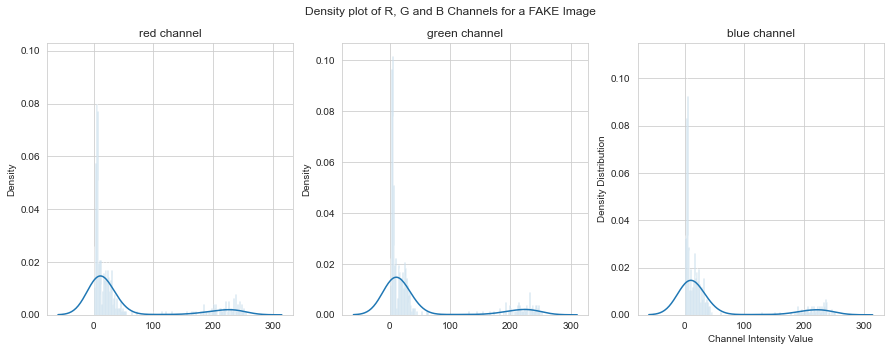

In [201]:
# FAKE face image analysis
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(ax):
    df = img_fake_channels[i].ravel()
    sns.distplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(channels[i]+' channel')
plt.suptitle("Density plot of R, G and B Channels for a FAKE Image ")
plt.xlabel("Channel Intensity Value")
plt.ylabel("Density Distribution")
plt.show()


### Objective 3: 
##### We will try to find out the contribution of each channel in creating a REAL or FAKE image.(Using single example):

Text(0, 0.5, 'Pixel count')

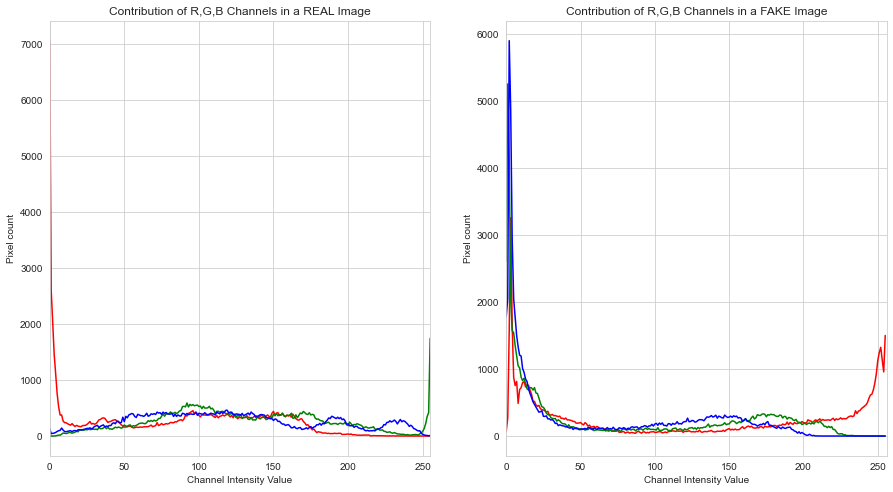

In [202]:
# Tuple to select colors of each channel line
colors = ("red", "green", "blue")

# create the histogram plot, with three lines, one for
# each color
plt.figure(figsize = [15, 8])

plt.subplot(1, 2, 1)
plt.xlim([0, 255])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        img_real[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.title("Contribution of R,G,B Channels in a REAL Image")
plt.xlabel("Channel Intensity Value")
plt.ylabel("Pixel count")

plt.subplot(1, 2, 2)
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        img_fake[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.title("Contribution of R,G,B Channels in a FAKE Image")
plt.xlabel("Channel Intensity Value")
plt.ylabel("Pixel count")

### Observations: 
##### Analyzing the properties of a single image does not help in concluding if any particular pattern exists in REAL vs FAKE images.
##### Hence, we will try to implement this approach to the whole sample space of Real and Fake images.

### Trying to find mean values of R,G,B channels after stacking all REAL images together and all Fake Images together:

In [203]:
#Sample code to print summary of an image
def print_single_image_summary(image, labels):
    
    print('--------------')
    print('Image Details:')
    print('--------------')
    print(f'Image dimensions: {image.shape}')
    print('Channels:')
    
    if len(labels) == 1:
        image = image[..., np.newaxis] #elipsis notation
        
    for i, lab in enumerate(labels):
        # print("Values", image[:,:,i])
        min_val = np.min(image[:,:,i])
        max_val = np.max(image[:,:,i])
        print(f'{lab} : min={min_val:.4f}, max={max_val:.4f}')

In [204]:
print_single_image_summary(imgs_real[1], ['R', 'G', 'B'])

--------------
Image Details:
--------------
Image dimensions: (256, 256, 3)
Channels:
R : min=7.0000, max=233.0000
G : min=4.0000, max=237.0000
B : min=0.0000, max=244.0000


### A Comparative Study Using RGB Analysis:

##### We will merge the 50K REAL images together by taking mean of intensities corresponding to each channel (i.e. R, G, and B) to get a sense of average contribution of each channel to the overall REAL images dataset.
##### We will do the same for FAKE images dataset too.

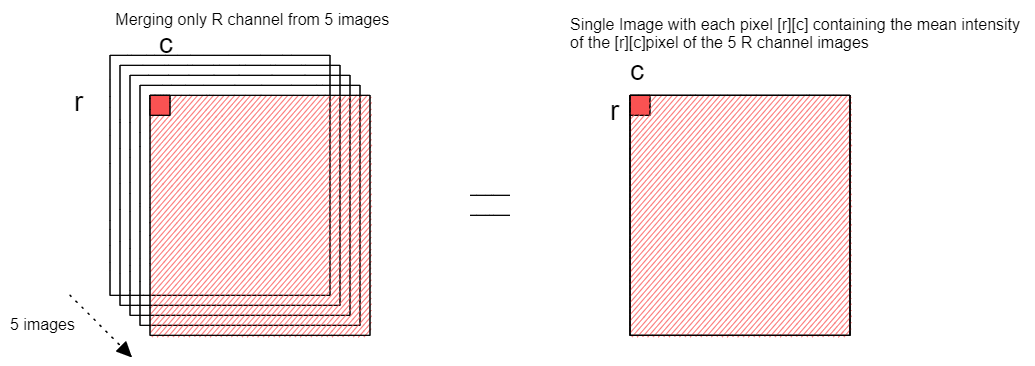

In [205]:
def calc_stack_image_single_channel_mean(image_list, label):
    print('--------------')
    print('Image Details:')
    print('--------------')
    print("Number of images to be stacked: ", len(image_list)) 
    print('--------------')
    print("Color channel : ", label)
    
    label_map = {0:'Red', 1:'Green', 2:'Blue'}
    
    # To hold red channel image
    single_channel_img = np.zeros((256,256,1))
    
    # To hold list of red channel images corresponding to each image in the list 'image_list'
    single_channel_img_list = []
    
    for img in image_list:
        # print(img.shape)
        # 0 is for Red channel
        # 1 is for Green channel
        # 2 is for Blue channel
        single_channel_img = img[:,:,label]
        single_channel_img_list.append(single_channel_img)
    
    # print(red_img_list)
    # Stack all single channel images together to calculate mean of corresponding pixel values
    single_channel_img_stack = np.stack(single_channel_img_list)
    # print(single_channel_img_stack.shape)
    single_channel_mean_img = np.mean(single_channel_img_stack, axis = 0)
    # print(f'{label_map[label]} pixel mean intensity image : , {single_channel_mean_img}')
    return single_channel_mean_img
        
  

In [206]:
# for real images:
n_sample = 50000
red_channel_mean_img_real = calc_stack_image_single_channel_mean(imgs_real[0:n_sample], 0)  
green_channel_mean_img_real = calc_stack_image_single_channel_mean(imgs_real[0:n_sample], 1)  
blue_channel_mean_img_real = calc_stack_image_single_channel_mean(imgs_real[0:n_sample], 2)  

all_channel_mean_img_real = np.stack([red_channel_mean_img_real, green_channel_mean_img_real, blue_channel_mean_img_real])

all_channel_mean_img_real.shape

--------------
Image Details:
--------------
Number of images to be stacked:  50000
--------------
Color channel :  0
--------------
Image Details:
--------------
Number of images to be stacked:  50000
--------------
Color channel :  1
--------------
Image Details:
--------------
Number of images to be stacked:  50000
--------------
Color channel :  2


(3, 256, 256)

In [207]:
# for Fake:
n_sample = 50000
red_channel_mean_img_fake = calc_stack_image_single_channel_mean(imgs_fake[0:n_sample], 0)  
green_channel_mean_img_fake = calc_stack_image_single_channel_mean(imgs_fake[0:n_sample], 1)  
blue_channel_mean_img_fake = calc_stack_image_single_channel_mean(imgs_fake[0:n_sample], 2)  

all_channel_mean_img_fake = np.stack([red_channel_mean_img_fake, green_channel_mean_img_fake, blue_channel_mean_img_fake])

all_channel_mean_img_fake.shape

--------------
Image Details:
--------------
Number of images to be stacked:  50000
--------------
Color channel :  0
--------------
Image Details:
--------------
Number of images to be stacked:  50000
--------------
Color channel :  1
--------------
Image Details:
--------------
Number of images to be stacked:  50000
--------------
Color channel :  2


(3, 256, 256)

### Objective 4:
#### Trying to find the RGB channels' density difference for Real and Fake Images (Using whole sample space):

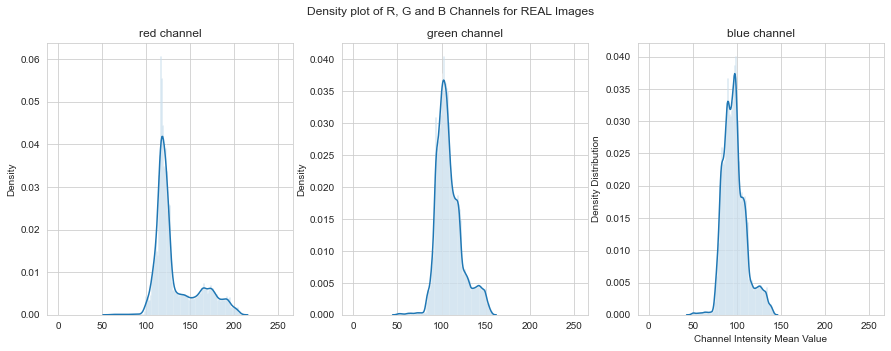

In [208]:
# REAL face image analysis (Density plot)
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(ax):
    df = all_channel_mean_img_real[i].ravel()
    sns.distplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(channels[i]+' channel')
plt.suptitle("Density plot of R, G and B Channels for REAL Images ")
plt.xlabel("Channel Intensity Mean Value")
plt.ylabel("Density Distribution")
plt.show()

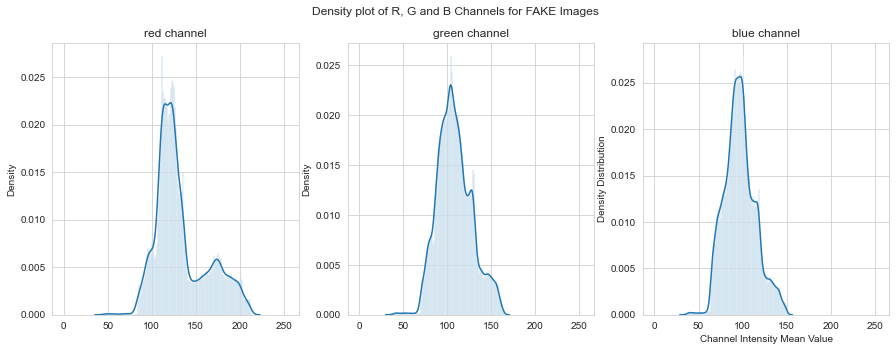

In [209]:
# FAKE face image analysis (Density plot)
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(ax):
    df = all_channel_mean_img_fake[i].ravel()
    sns.distplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(channels[i]+' channel')
plt.suptitle("Density plot of R, G and B Channels for FAKE Images ")
plt.xlabel("Channel Intensity Mean Value")
plt.ylabel("Density Distribution")
plt.show()


### Observations: 
It can be observed that the R,G,B channel's have higher overall density for REAL images dataset than the FAKE images dataset.
Hence, for a better view, we will try to collate all three channels in one plot.

Text(0.5, 0.98, 'Comparison of Mean Contribution of RGB Channels in Real and Fake Images')

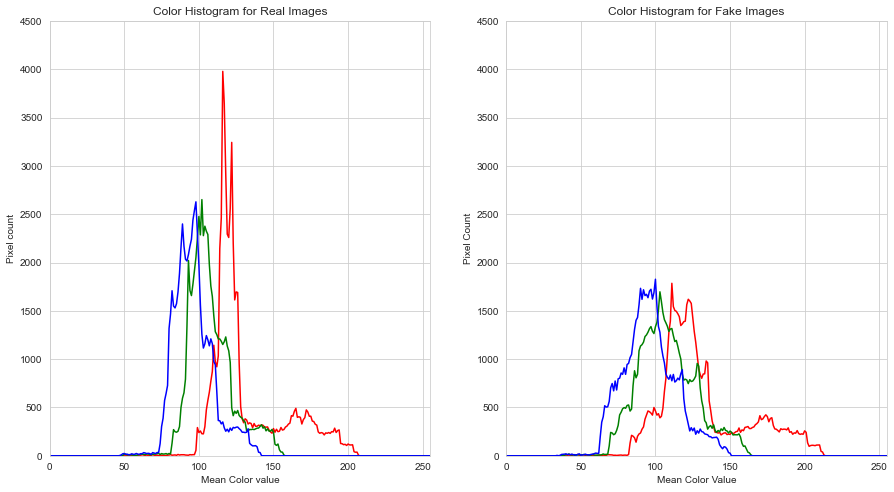

In [210]:
# Plotting together:

colors = ("red", "green", "blue")

# create the histogram plot, with three lines, one for each color
plt.figure(figsize = [15, 8])

plt.subplot(1, 2, 1)
plt.ylim([0, 4500])
plt.xlim([0, 255])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        all_channel_mean_img_real[channel_id, :, :], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)
plt.title("Color Histogram for Real Images")
plt.xlabel("Mean Color value")
plt.ylabel("Pixel count")
    
plt.subplot(1, 2, 2)
plt.ylim([0, 4500])
plt.xlim([0, 255])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        all_channel_mean_img_fake[channel_id, :, :], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)



plt.title("Color Histogram for Fake Images")
plt.xlabel("Mean Color Value")
plt.ylabel("Pixel Count")
fig.suptitle('Comparison of Mean Contribution of RGB Channels in Real and Fake Images', fontsize=16)



#### Conclusion: 
- The contribution of intensity of RGB channel in pixel count is higher for Real image as compared to the Fake images.
- There is significant decrease in contribution of Red channel intensity in Fake images as compared to Real images.
- Now, this seems more intuitive that since Fake images are generated by a machine (it has a kind of recipe which considers hard values of proportions of R, G, B channels to create an image). However, REAL images does not follow such pattern.
- This can be used further as a feature to detect a Fake image.
